In [1]:
from transformers import PreTrainedTokenizerFast

TOKENIZER_PATH = "./tokenizer.json"

tokenizer = PreTrainedTokenizerFast(tokenizer_file=TOKENIZER_PATH)
tokenizer.pad_token = "[PAD]"
tokenizer.sep_token = "[SEP]"
tokenizer.mask_token = "[MASK]"
tokenizer.cls_token = "[CLS]"
tokenizer.unk_token = "[UNK]"

In [2]:
from transformers import BertForMaskedLM
# model = BertForMaskedLM.from_pretrained("./pictobertimbau-related-words")
# model = BertForMaskedLM.from_pretrained("./pictobertimbau-def-input_mean")
model = BertForMaskedLM.from_pretrained("./pictobertimbau-captions")


In [7]:
# eu quero = 5441
sequence = "5441 [MASK] 3218"
tokens = tokenizer.tokenize(sequence)

In [8]:
from tinydb import TinyDB,Query
import re
Pictogram = Query()
Keyword = Query()
db = TinyDB("pictograms.json")
picograms = db.table("pictogram")

def get_by_id(id_):
  pics = picograms.search(Pictogram._id == int(id_))
  if len(pics) > 0:
    return pics[0]
  return None


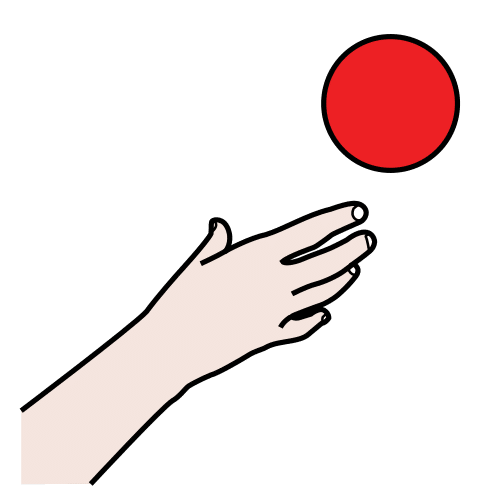


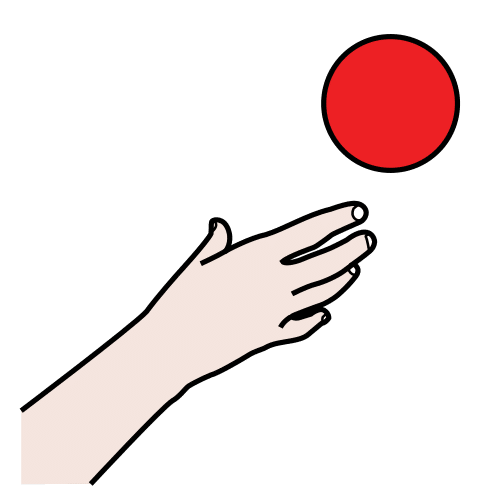

In [9]:
from io import BytesIO
from PIL import Image
import ipyplot
import requests

def show_sentence(pictograms,probs=None):
    images, labels = [],[]
    if probs == None:
        probs = [None] *len(pictograms)
    for i,token in enumerate(pictograms):
        if token.isnumeric() and int(token) != 3218:
            pictogram = get_by_id(token)
            if pictogram is not None:
                url = "https://api.arasaac.org/api/pictograms/{0}?download=false".format(token)

                response = requests.get(url)
                images.append(Image.open(BytesIO(response.content)))
                prob = probs[i]
                if prob is None:
                    labels.append(pictogram['keywords'][0]['keyword']+"\n"+token)
                else:
                    labels.append("{0} {1} ({2:10.4f})".format(pictogram['keywords'][0]['keyword'],token,prob))
    ipyplot.plot_images(images,labels)

show_sentence(tokens)


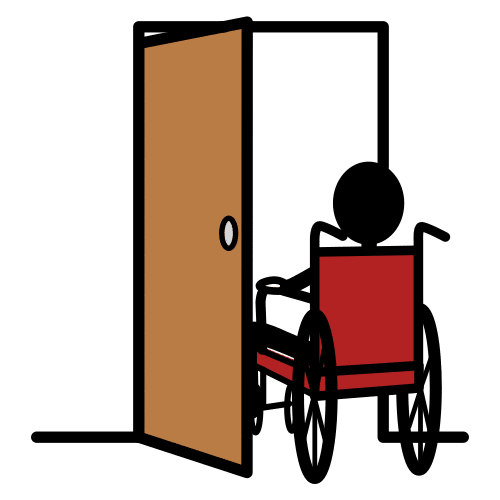
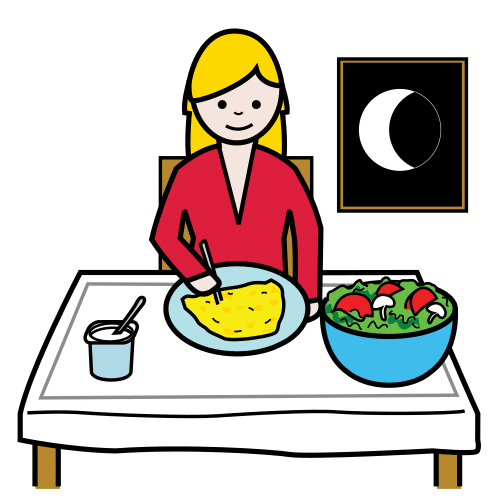
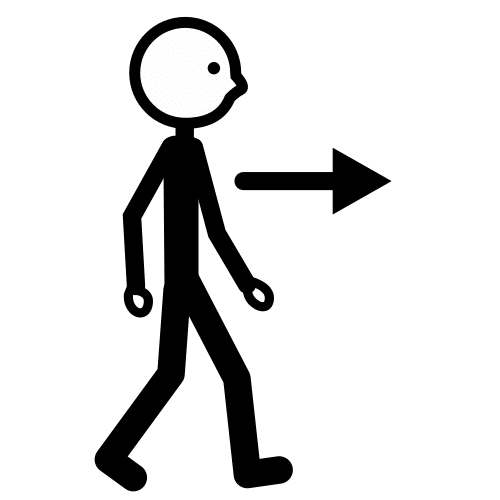
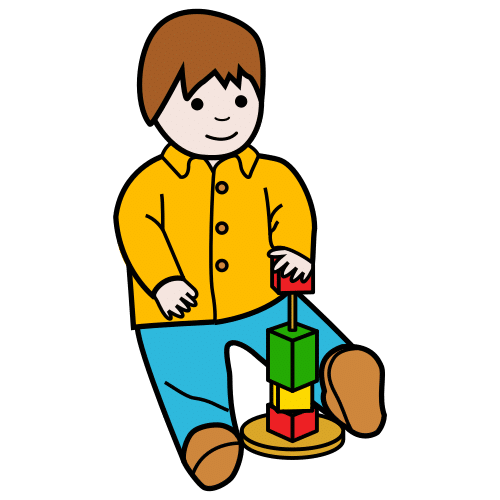
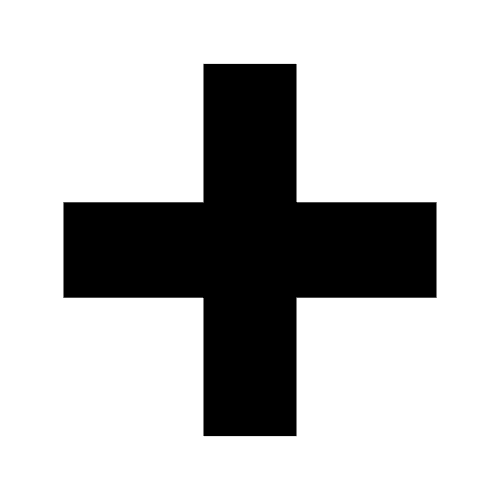
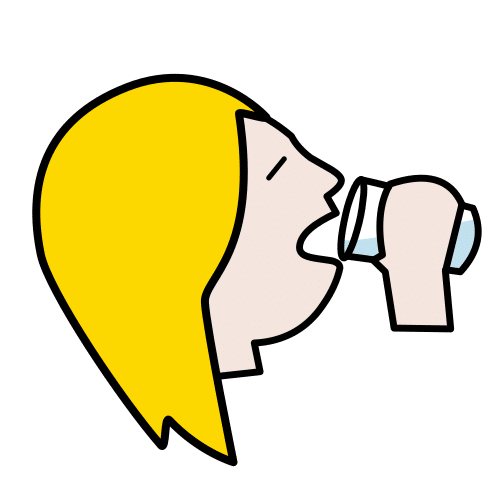
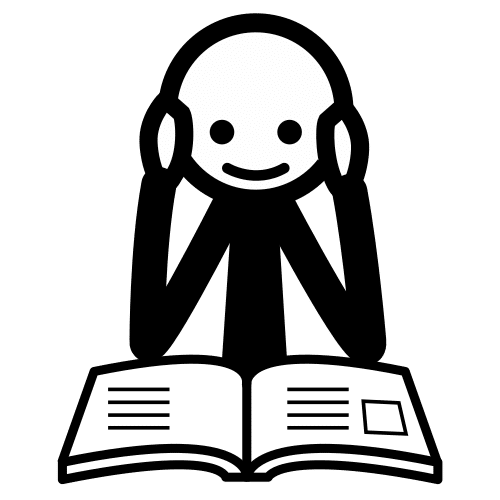
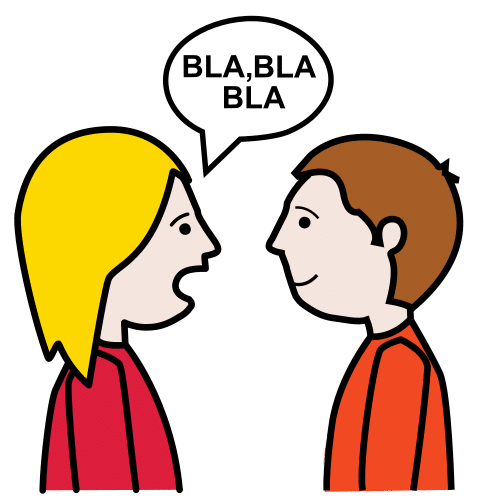
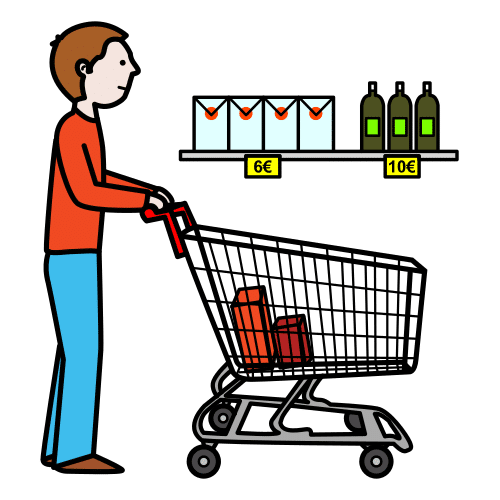
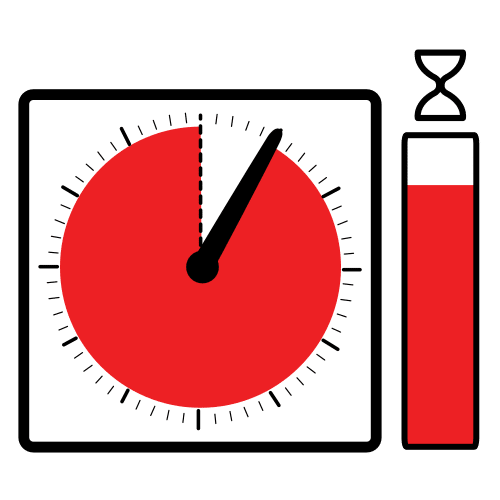
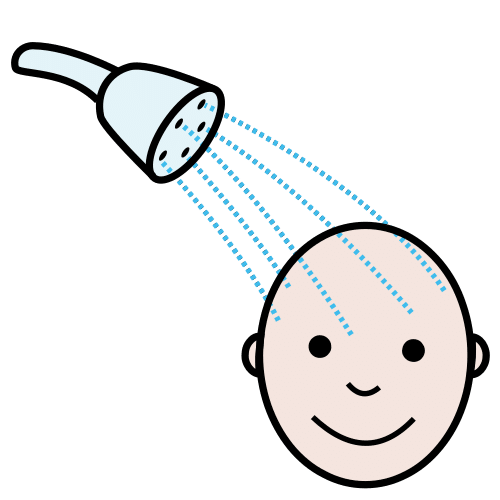
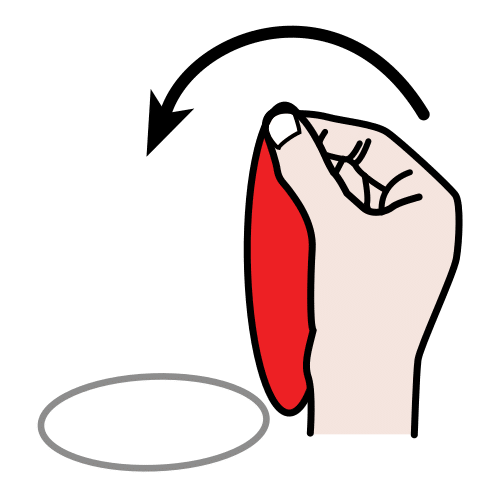
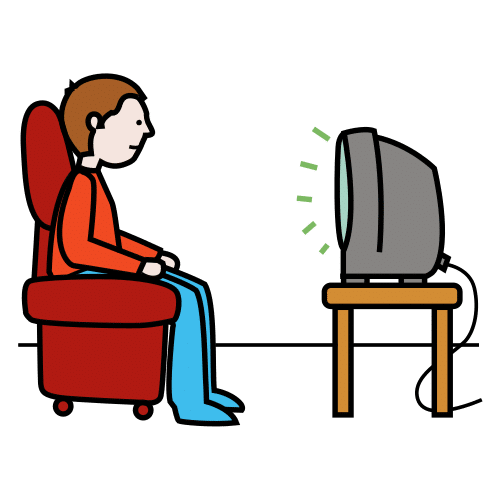
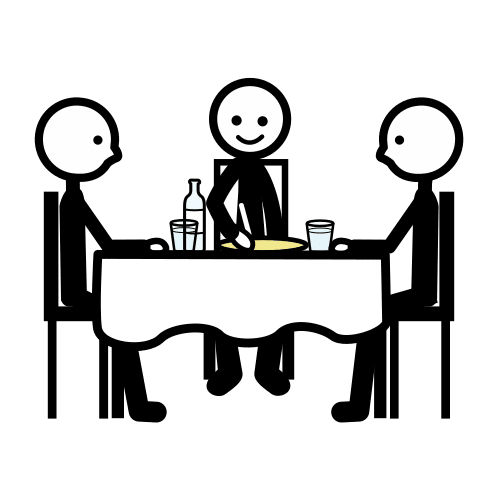
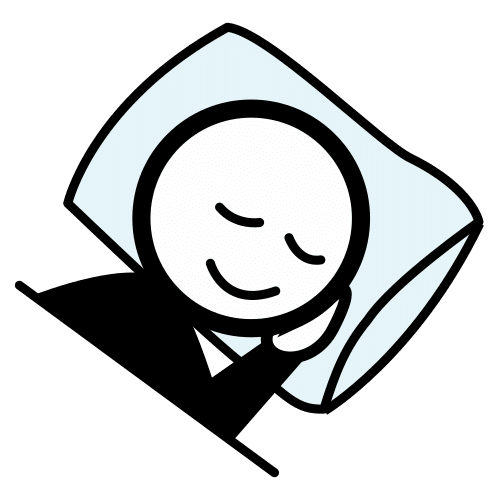
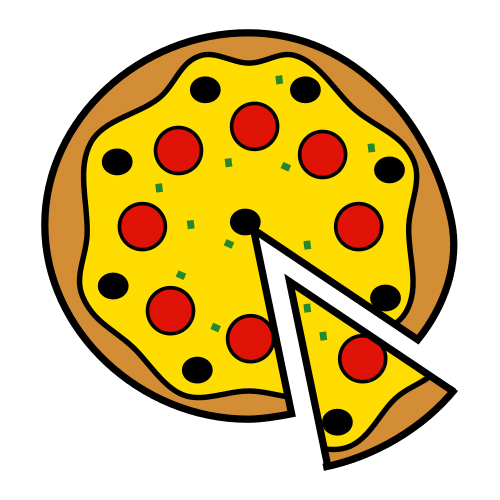
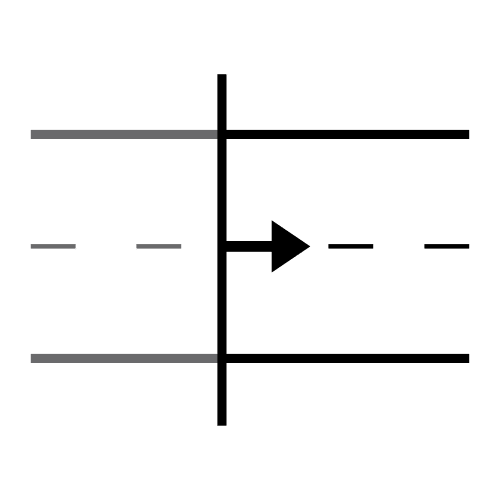
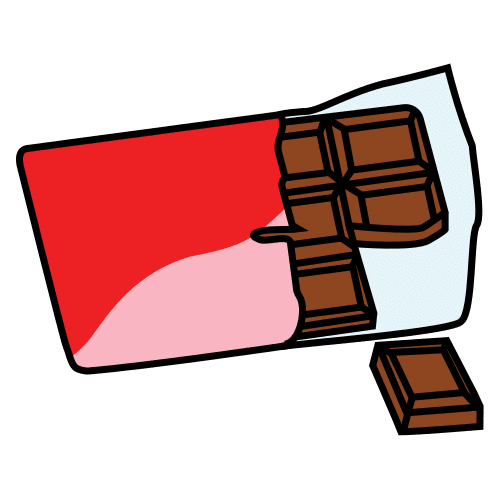
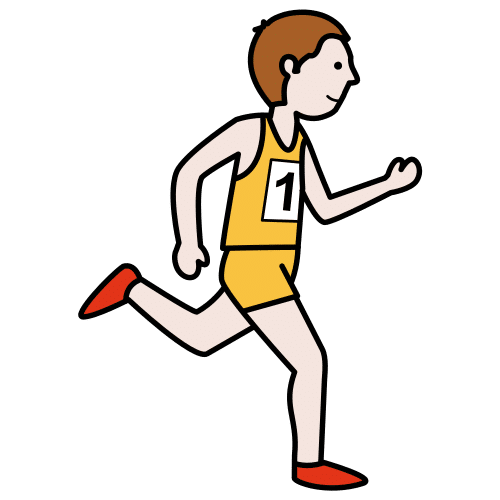
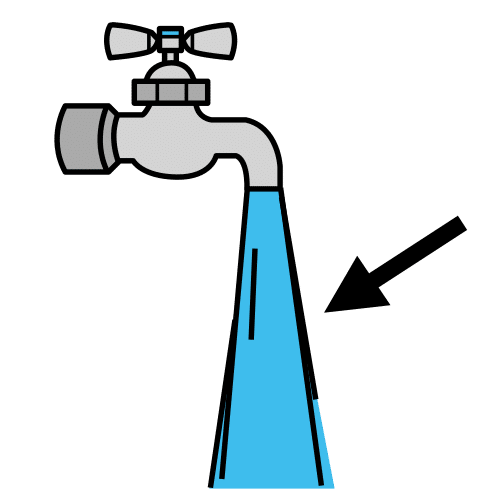


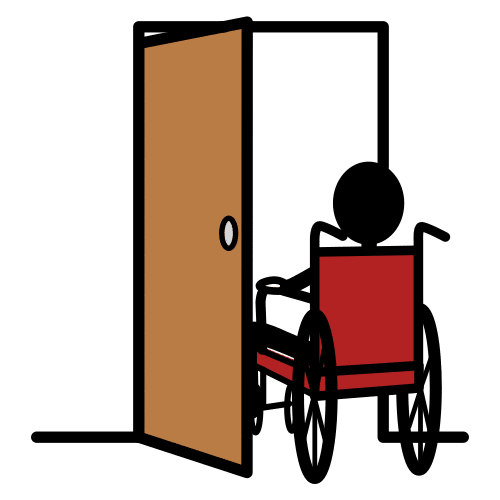
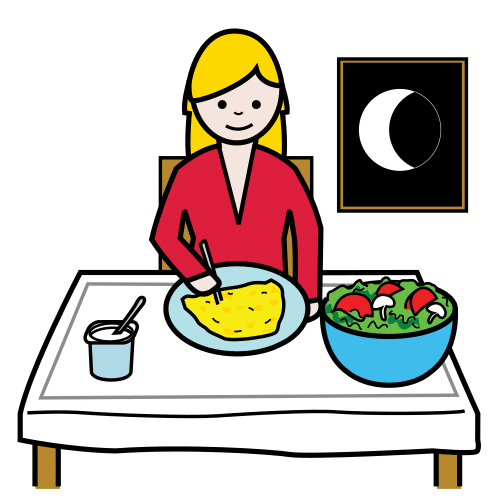
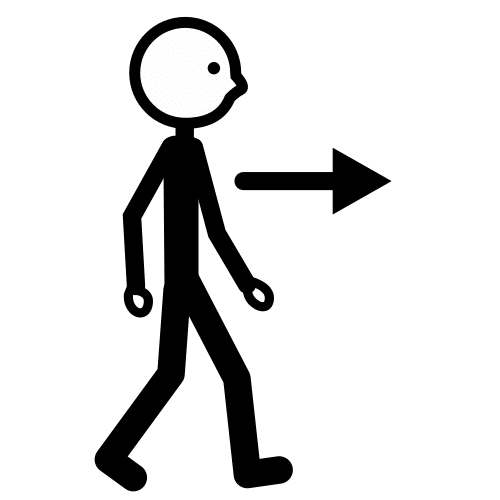
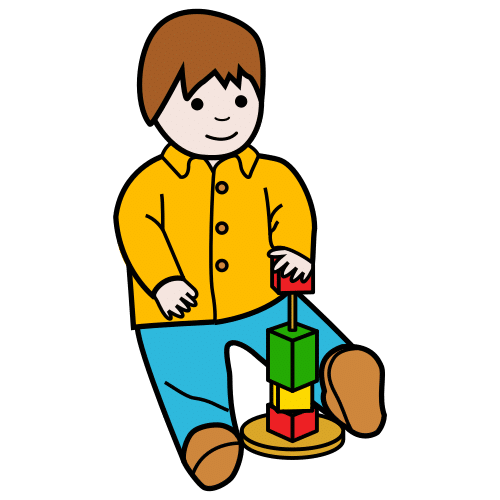
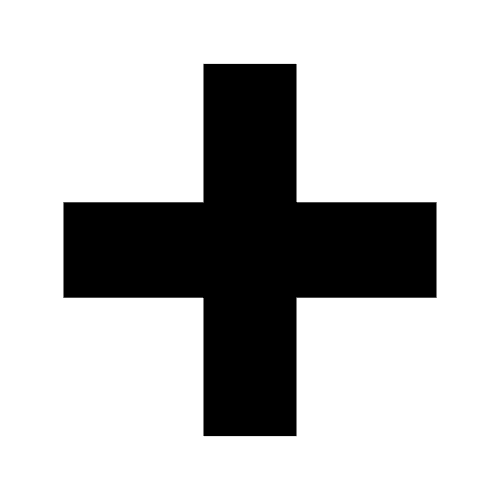
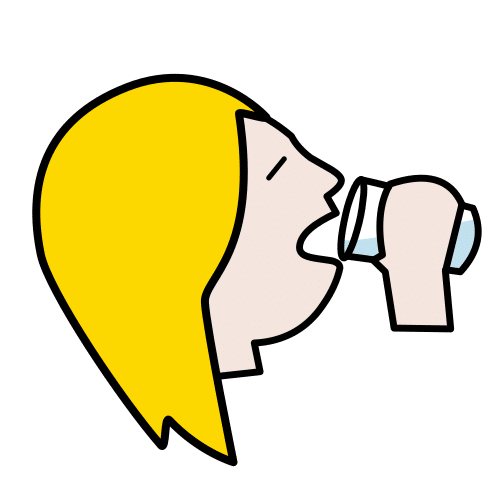
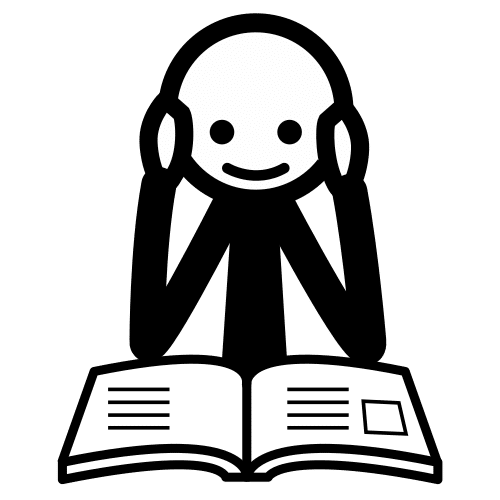
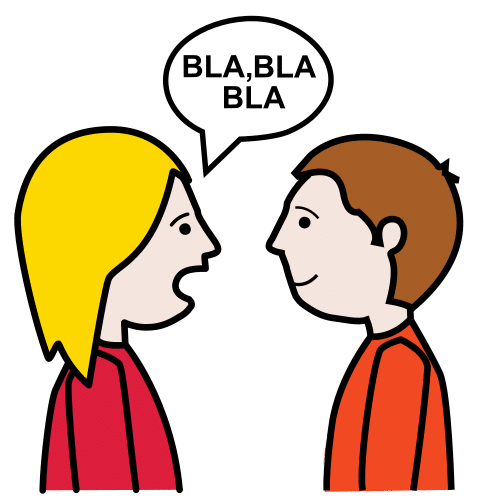
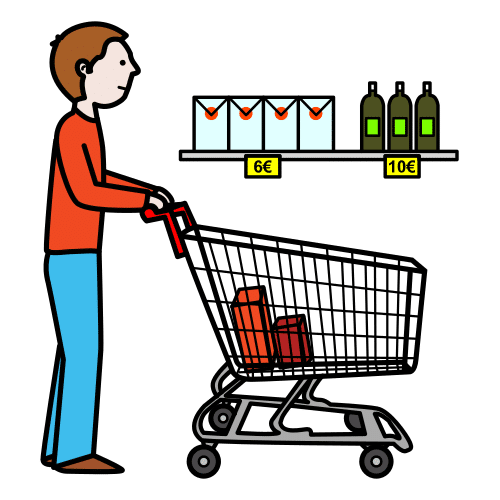
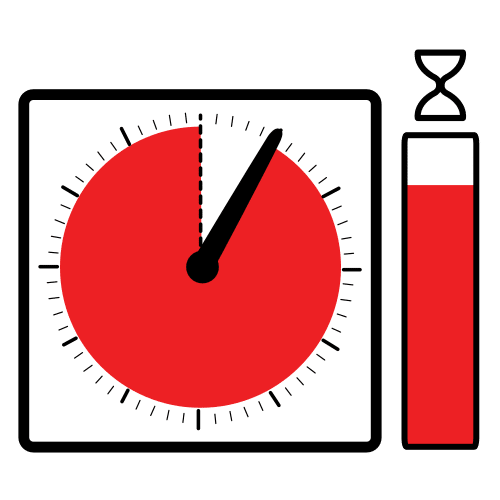
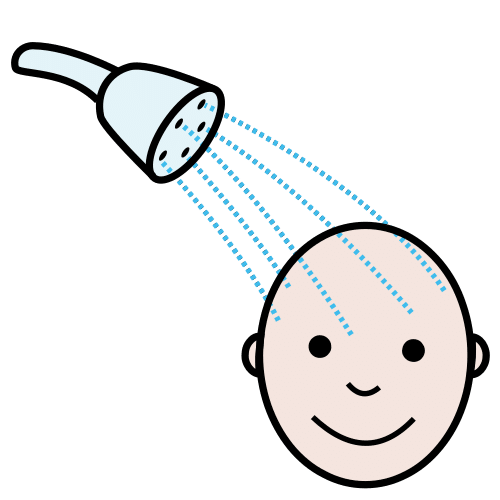
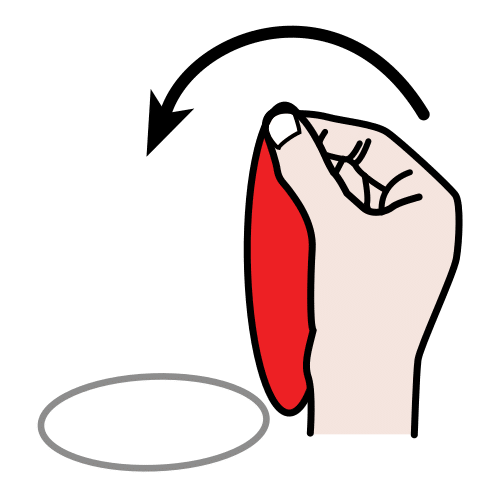
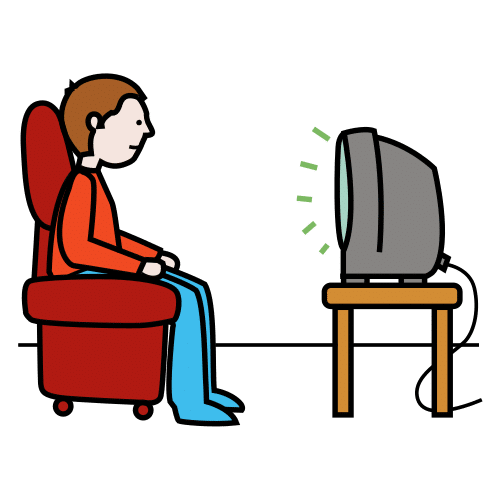
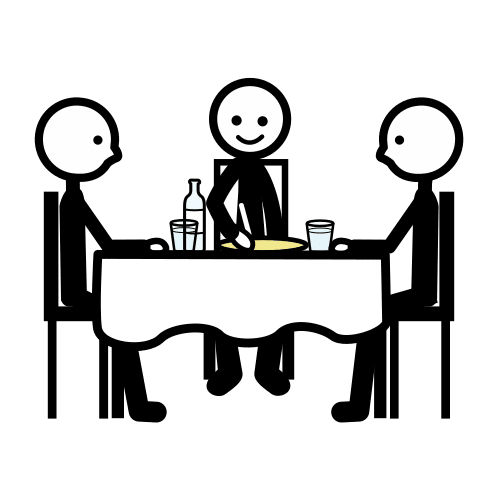
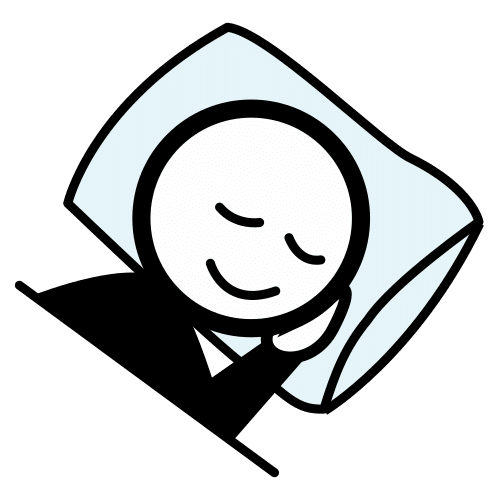
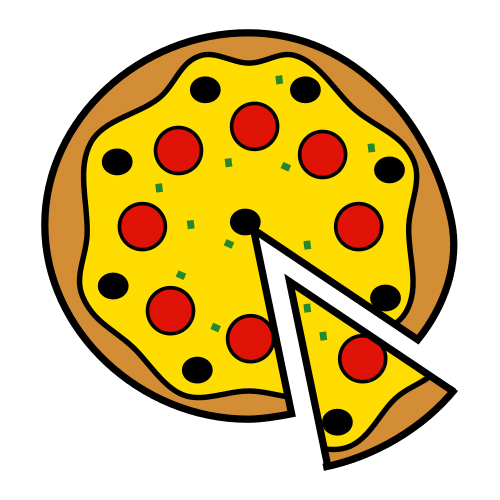
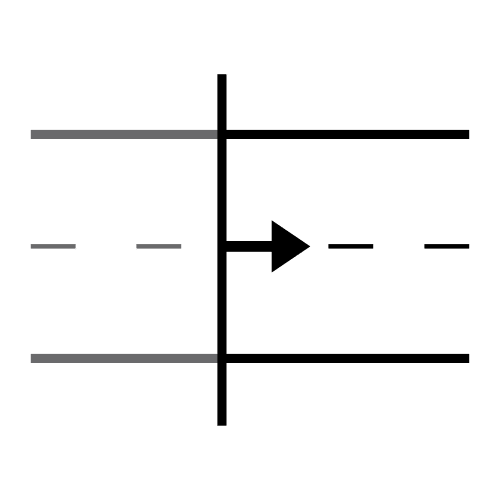
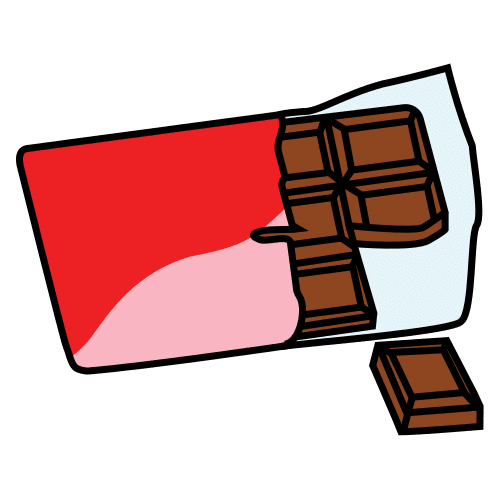
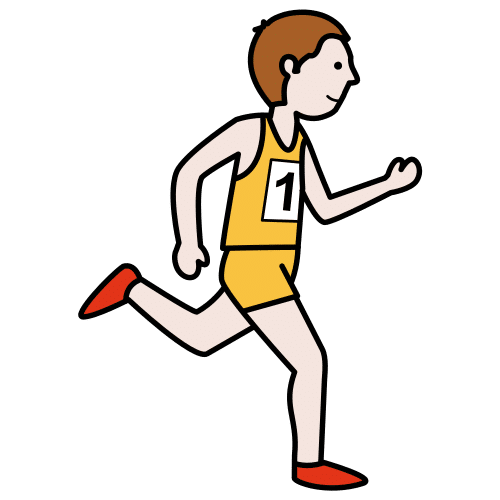
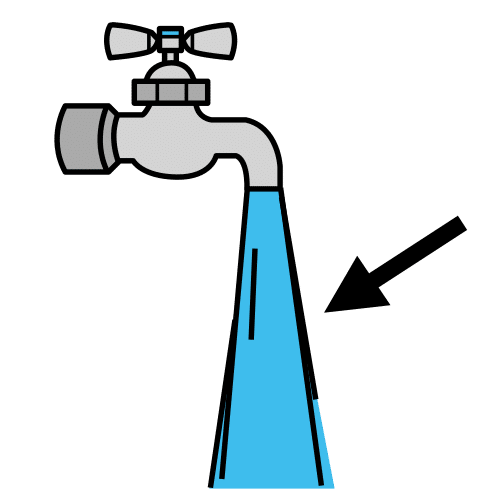

In [10]:
import torch.nn.functional as F
import numpy as np
top_k = 20
input = tokenizer(sequence,return_tensors='pt')

output = model(input['input_ids'], input['attention_mask'])

predictions = F.softmax(output[0], dim=-1)

predictions.size()

mask_idx = input['input_ids'].tolist()[0].index(tokenizer.mask_token_id)
probs = predictions[0, mask_idx, :]
res = tokenizer.convert_ids_to_tokens(probs.topk(top_k)[1])

# top_pictograms = [cards_vocab[w] for w in top_words]
show_sentence(res, probs.topk(top_k)[0])